In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
from tensorflow import keras as keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import cudf
import os
import datetime
from scipy.stats import zscore

2024-01-11 22:43:23.055283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [9]:
df = pd.read_csv('./data/train_data_histogram_longtime_210000_coursegrained.csv')

y = df['output_val']
X = df.drop(['output_val'], axis=1)

X_original = X.copy()
y_original = y.copy()

# normalize the data with max-min normalization
# X = (X - X.min()) / (X.max() - X.min())
# y= (y - y.min()) / (y.max() - y.min())

# use standard scaler to normalize the data making sure that each column is normalized separately
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Names of the columns in df
print(df.columns)

ValueError: Expected 2D array, got 1D array instead:
array=[9.85934113 2.99722947 9.85934113 ... 7.9705789  7.9705789  7.9705789 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)

X_train: (1679200, 2)
X_test: (419801, 2)


In [10]:
# # # Load previously trained model
# model = tf.keras.models.load_model('models/histogram_longtime_210000_coursegrained_aug1_relu_bestmodel_loss0013_120neurons')

In [11]:
# model = keras.Sequential([
#     keras.layers.Dense(120, activation='tanh', input_shape=(2,), kernel_initializer='glorot_normal'),
#     keras.layers.Dropout(0.1),
#     keras.layers.Dense(60, activation='tanh', kernel_initializer='glorot_normal'),
#     keras.layers.Dropout(0.1),
#     keras.layers.Dense(60, activation='tanh', kernel_initializer='glorot_normal'),
#     keras.layers.Dense(30, activation='tanh', kernel_initializer='glorot_normal'),
#     keras.layers.Dense(1)
# ])

In [12]:
model = keras.Sequential([
    keras.layers.Dense(120, activation='relu', input_shape=(2,)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])

In [13]:
# Create the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

# Compile the model
# model.compile(optimizer=optimizer, loss='mse', jit_compile=True)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
epochs = 300  # Number of training iterations
batch_size = 8500  # Number of samples per gradient update
# batch_size = 64

# Create a learning rate scheduler

lr_scheduler = ReduceLROnPlateau(factor=0.3, patience=300, min_lr=0.001)

# Create an early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1500, mode="min", restore_best_weights=True)

# Create a csv logger
csv_logger = tf.keras.callbacks.CSVLogger('training.log')

# Add the scheduler to the callbacks list
callbacks = [lr_scheduler, early_stopping_callback]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=0.2)

Epoch 1/300
159/159 [==============================] - 1s 3ms/step - loss: 0.8503 - val_loss: 0.6872 - lr: 1.0000e-04
Epoch 2/300
159/159 [==============================] - 0s 2ms/step - loss: 0.6328 - val_loss: 0.5756 - lr: 1.0000e-04
Epoch 3/300
159/159 [==============================] - 0s 2ms/step - loss: 0.5829 - val_loss: 0.5581 - lr: 1.0000e-04
Epoch 4/300
159/159 [==============================] - 0s 2ms/step - loss: 0.5688 - val_loss: 0.5502 - lr: 1.0000e-04
Epoch 5/300
159/159 [==============================] - 0s 2ms/step - loss: 0.5607 - val_loss: 0.5449 - lr: 1.0000e-04
Epoch 6/300
159/159 [==============================] - 0s 2ms/step - loss: 0.5547 - val_loss: 0.5419 - lr: 1.0000e-04
Epoch 7/300
159/159 [==============================] - 0s 2ms/step - loss: 0.5505 - val_loss: 0.5391 - lr: 1.0000e-04
Epoch 8/300
159/159 [==============================] - 0s 2ms/step - loss: 0.5472 - val_loss: 0.5374 - lr: 1.0000e-04
Epoch 9/300
159/159 [==============================] - 0

KeyboardInterrupt: 

In [9]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

13119/13119 [==============================] - 8s 633us/step - loss: 9.4875e-04
Test loss: 0.0009487492498010397
13119/13119 [==============================] - 7s 507us/step


In [10]:
# Save the model
# model.save("saved_models/histogram_longtime_210000_coursegrained_jan3_relu_bestmodel_loss0p0007_120neurons")

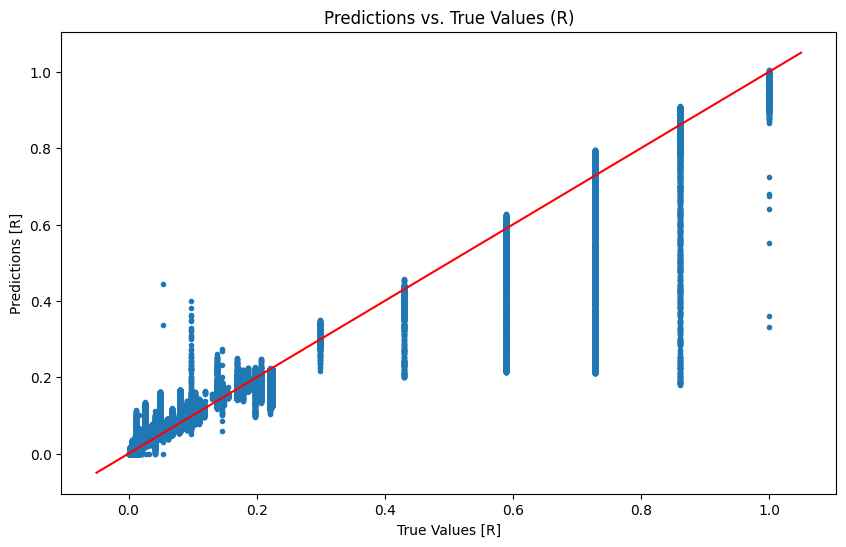

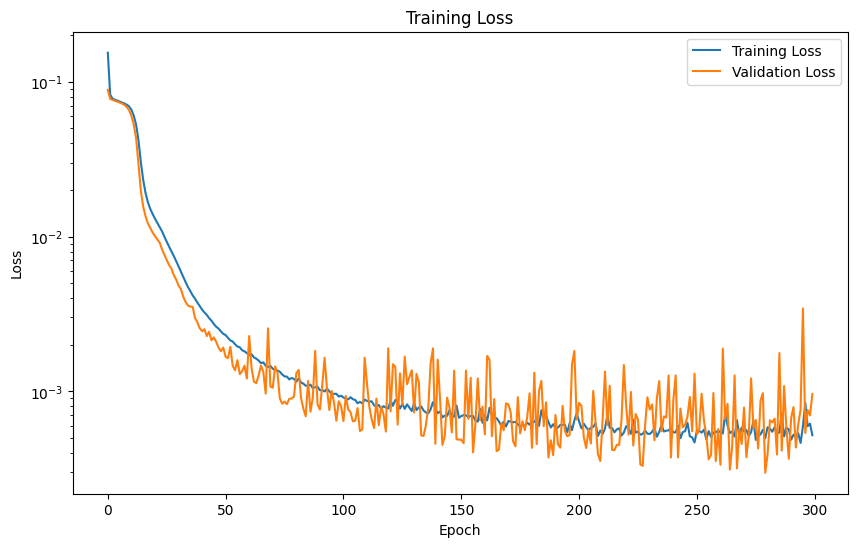

In [11]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(y_test).iloc[:,0], predictions, '.')
# plt.plot(y_test_2d, predictions, '.')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
# Make a 45 degree line in the same scale and range
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')

# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [29]:
# extract U and R from the test data
U_test = X_test.iloc[:,0]
R_test = X_test.iloc[:,1]
output_test = y_test.iloc[:]

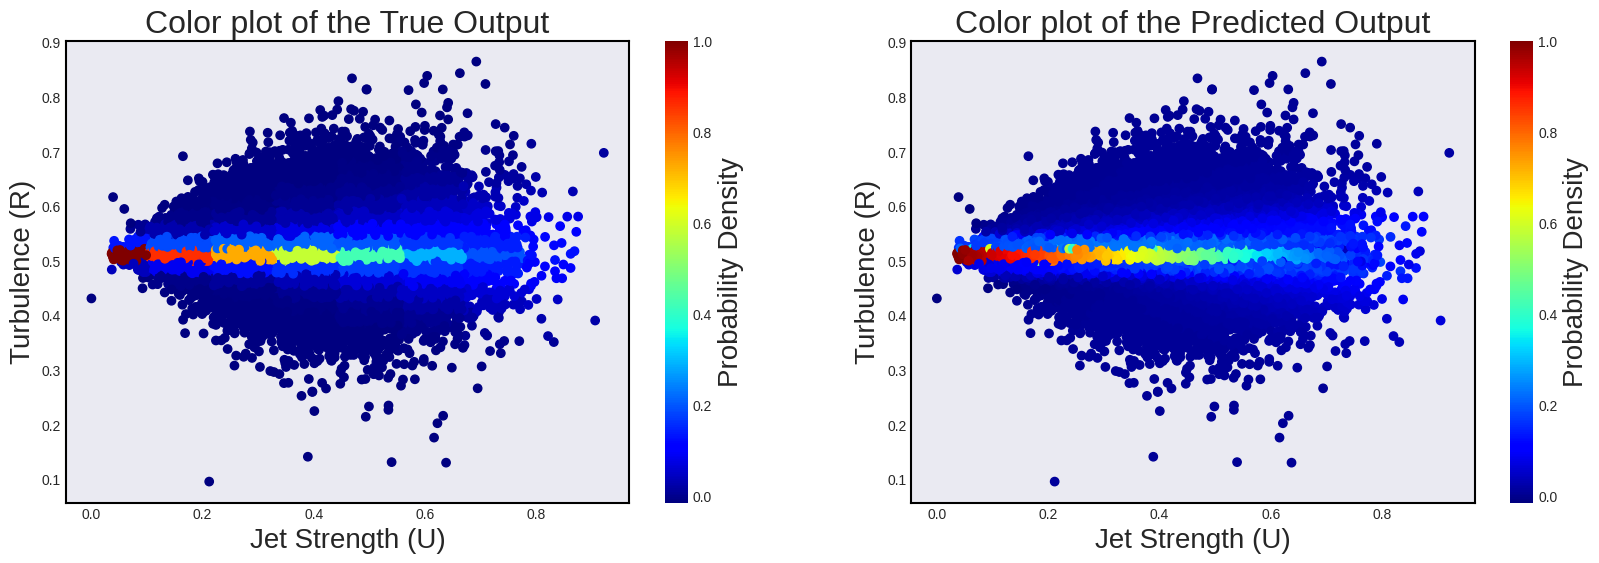

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# Your existing code for the scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

scatter1 = ax1.scatter(U_test, R_test, c=output_test, cmap='jet')
ax1.set_xlabel('Jet Strength (U)', fontsize=20)
ax1.set_ylabel('Turbulence (R)', fontsize=20)
ax1.set_title('Color plot of the True Output', fontsize=23)

scatter2 = ax2.scatter(U_test, R_test, c=predictions.reshape(-1), cmap='jet')
ax2.set_xlabel('Jet Strength (U)', fontsize=20)
ax2.set_ylabel('Turbulence (R)', fontsize=20)
ax2.set_title('Color plot of the Predicted Output', fontsize=23)

# Create ScalarMappable objects for the colorbars
norm = colors.Normalize(vmin=min(min(output_test), min(predictions.reshape(-1))), vmax=max(max(output_test), max(predictions.reshape(-1))))
sm = cm.ScalarMappable(cmap='jet', norm=norm)

# Add colorbars
cbar1 = fig.colorbar(sm, ax=ax1)
cbar1.set_label('Probability Density', fontsize=20)
cbar2 = fig.colorbar(sm, ax=ax2)
cbar2.set_label('Probability Density', fontsize=20)

# Modify spines to add borders
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.5)

plt.show()


In [31]:
U_np = np.array(U_test)
R_np = np.array(R_test)
output_np = np.array(output_test)

new_U = np.linspace(np.min(U_np), np.max(U_np), 100)
new_R = np.linspace(np.min(R_np), np.max(R_np), 100)

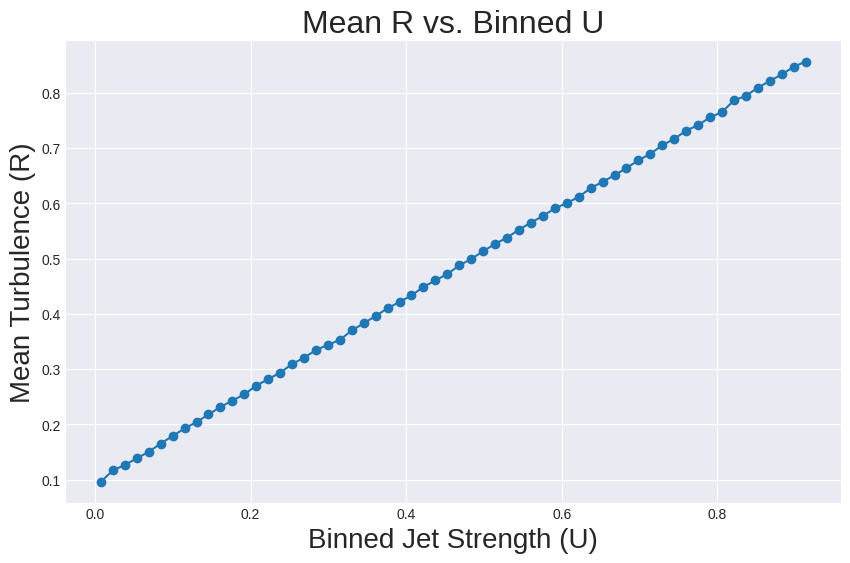

In [65]:
# Define the number of bins
num_bins = 60

# Bin the U values
bins = np.linspace(np.min(new_U), np.max(new_U), num_bins+1)
digitized = np.digitize(new_U, bins)

# Initialize arrays for sums
sum_RP = np.zeros(num_bins)
sum_P = np.zeros(num_bins)

# Calculate sums for each bin iteratively
for i in range(len(new_U)):
    bin_index = digitized[i] - 1  # Array index starts from 0
    if 0 <= bin_index < num_bins:
        sum_RP[bin_index] += new_R[i] * predictions[i]
        sum_P[bin_index] += predictions[i]

# Calculate mean R for each bin
mean_R_per_bin = np.divide(sum_RP, sum_P, out=np.zeros_like(sum_RP), where=sum_P != 0)

# Midpoints of bins for plotting
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bin_midpoints, mean_R_per_bin, marker='o')
plt.xlabel('Binned Jet Strength (U)', fontsize=20)
plt.ylabel('Mean Turbulence (R)', fontsize=20)
plt.title('Mean R vs. Binned U', fontsize=23)
plt.grid(True)
# plt.xlim(0, 0.3)
# plt.ylim(-0.01, 0.03)
plt.show()

In [53]:
# Assuming U_test, R_test, and predictions are already defined
# Flatten the predictions to ensure it is 1D
predictions = predictions.flatten()

# Perform a weighted linear regression using numpy's polyfit function
# This function returns the coefficients of the fitted polynomial
coefficients = np.polyfit(U_test, R_test, deg=1, w=np.sqrt(predictions))

# Create a polynomial from these coefficients
polynomial = np.poly1d(coefficients)

# Calculate the values on the regression line
U_line = np.linspace(np.min(U_test), np.max(U_test), 100)
R_line = polynomial(U_line)

# Plot the original scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(U_test, R_test, c=predictions, cmap='jet', label='Predicted Output')

# Plot the regression line
plt.plot(U_line, R_line, color='red', label='Regression Line')

# Set axis labels and title with enhanced font sizes
plt.xlabel('Jet Strength (U)', fontsize=20)
plt.ylabel('Turbulence (R)', fontsize=20)
plt.title('Color plot of the Predicted Output with Regression Line', fontsize=23)

# Add a colorbar with label
cbar = plt.colorbar()
cbar.set_label('Probability Density', fontsize=20)

# Modify spines to add borders
ax = plt.gca()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Add a legend
plt.legend()

# Show the plot
plt.show()


 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/tmp/ipykernel_326878/4233757808.py:7: RuntimeWarning: invalid value encountered in sqrt
  coefficients = np.polyfit(U_test, R_test, deg=1, w=np.sqrt(predictions))


LinAlgError: SVD did not converge in Linear Least Squares

In [54]:
#plot the R_;ine vs U_line
plt.figure(figsize=(10, 6))
plt.plot(U_line, R_line, color='red', label='Regression Line')
plt.xlabel('Jet Strength (U)', fontsize=20)
plt.ylabel('Turbulence (R)', fontsize=20)
plt.title('Regression Line through P(R|U) plot', fontsize=23)
# plt.xlim(0.03, 0.3)
# plt.ylim(0.0005, 0.013)
plt.show()

NameError: name 'U_line' is not defined

<Figure size 1000x600 with 0 Axes>

## UN-NORMALIZING THE DATA

In [ ]:
# change the normalized data back to the original scale

X_test_original = X_test * (X_original.max() - X_original.min()) + X_original.min()
y_test_original = y_test * (y_original.max() - y_original.min()) + y_original.min()
predictions_original = predictions * (y_original.max() - y_original.min()) + y_original.min()

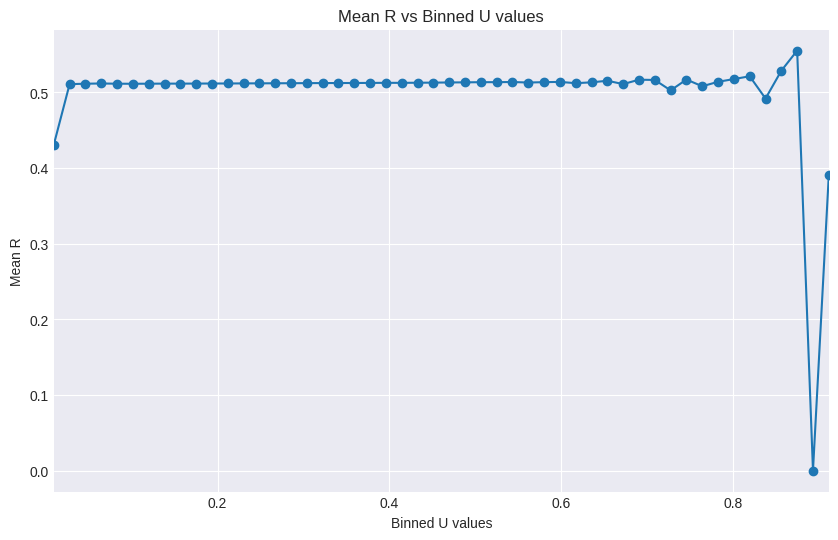

In [67]:
# Define the number of bins
num_bins = 50

# Bin the U values
bins = np.linspace(np.min(U_np), np.max(U_np), num_bins+1)
digitized = np.digitize(U_np, bins)

# Initialize arrays for sums
sum_RP = np.zeros(num_bins)
sum_P = np.zeros(num_bins)

# Calculate sums for each bin iteratively
for i in range(len(U_np)):
    bin_index = digitized[i] - 1  # Array index starts from 0
    if 0 <= bin_index < num_bins:
        sum_RP[bin_index] += R_np[i] * predictions[i]
        sum_P[bin_index] += predictions[i]

# Calculate mean R for each bin
mean_R_per_bin = np.divide(sum_RP, sum_P, out=np.zeros_like(sum_RP), where=sum_P != 0)

# Midpoints of bins for plotting
bin_midpoints = (bins[:-1] + bins[1:]) / 2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bin_midpoints, mean_R_per_bin, marker='o')
plt.xlabel('Binned U values')
plt.ylabel('Mean R')
plt.title('Mean R vs Binned U values')
plt.grid(True)
# plt.xlim(0, 0.6)
# plt.ylim(0.51, 0.5150)
#autoscale the plot
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()